In [8]:
# Package imports
import numpy as np                                  # "Scientific computing"
import pandas as pd                                 # Dataframe
from pandas.api.types import CategoricalDtype

import scipy.stats as stats                         # Statistical tests
from sklearn.linear_model import LinearRegression   # Linear regression model

import matplotlib.pyplot as plt                     # Basic visualisation
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic plot
import seaborn as sns                               # Advanced dataviz

In [7]:
df = pd.read_csv(filepath_or_buffer='../data/processed/load_testing/cybersecurity/1_register_fake_data.csv', delimiter=',', header=0, index_col=0)


df = df[df['count'] >= 30]
df.head(50)


,min,max,count,mean,p50,median,p75,p90,p95,p99,p999
id,,,,,,,,,,,
8,4,1282,31,712.5,671.9,671.9,757.6,1085.9,1249.1,1249.1,1249.1
10,344,1147,30,690.6,632.8,632.8,772.9,1085.9,1107.9,1130.2,1130.2
11,395,1189,30,703.6,658.6,658.6,804.5,889.1,1153.1,1153.1,1153.1
12,5,1292,37,672.0,645.6,645.6,788.5,925.4,1064.4,1224.4,1224.4
13,4,1200,41,692.7,788.5,788.5,854.2,1043.3,1085.9,1107.9,1107.9
14,3,1136,39,726.0,772.9,772.9,837.3,925.4,925.4,1022.7,1022.7
15,7,1060,39,706.4,788.5,788.5,854.2,944.0,944.0,1043.3,1043.3
16,3,1127,42,754.9,804.5,804.5,889.1,925.4,1064.4,1107.9,1107.9
17,4,5992,49,732.8,742.6,742.6,889.1,1022.7,1043.3,1274.3,1274.3


<Axes: xlabel='mean', ylabel='Count'>

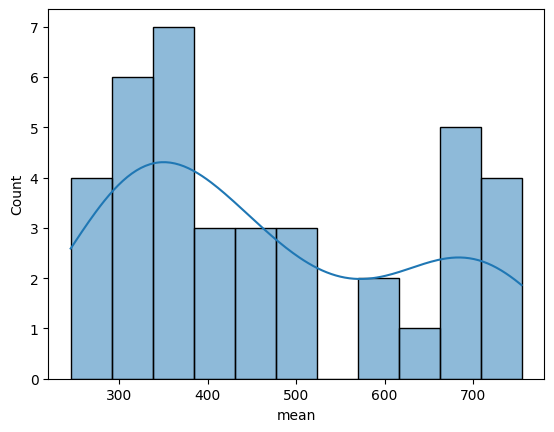

In [5]:
sns.histplot(data=df, x="mean", bins=11, kde=True)


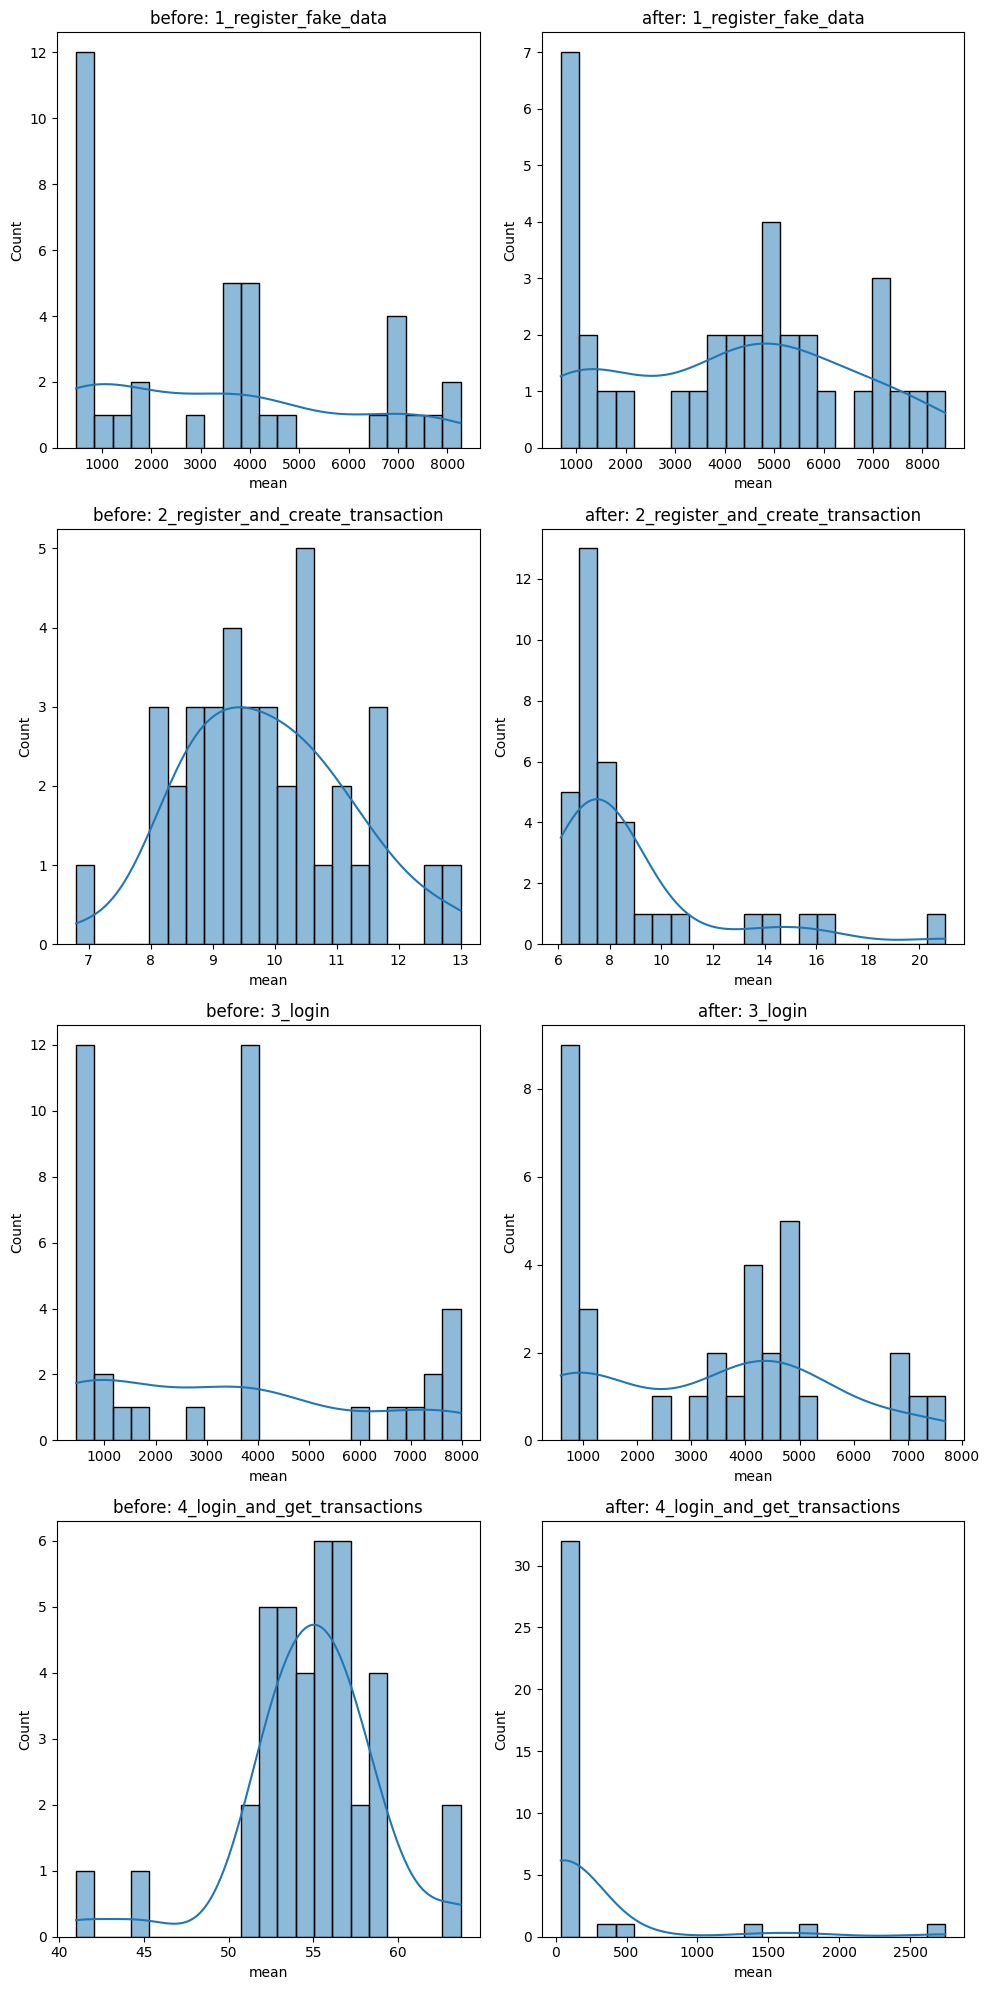

In [13]:
base_path = '../data/processed/load_testing'
scenarios = ['1_register_fake_data', '2_register_and_create_transaction', '3_login', '4_login_and_get_transactions']

figure, axes = plt.subplots(len(scenarios), 2, figsize=(10, 5*len(scenarios)))

for ax, scenario in zip(axes, scenarios):
    before = pd.read_csv(filepath_or_buffer=f'{base_path}/original/{scenario}.csv', delimiter=',', header=0, index_col=0)
    before = before[before['count'] >= 30]

    sns.histplot(data=before, x="mean",  bins=21, kde=True, ax=ax[0])
    ax[0].set_title(f'before: {scenario}')

    after = pd.read_csv(filepath_or_buffer=f'{base_path}/no-ratelimiter/{scenario}.csv', delimiter=',', header=0, index_col=0)
    after = after[after['count'] >= 30]

    sns.histplot(data=after, x="mean",  bins=21, kde=True, ax=ax[1])
    ax[1].set_title(f'after: {scenario}')

plt.tight_layout()
plt.savefig('output.png', dpi=300)
plt.show()



